# PLAN

- [X] Acquisition
    - [X] Select what list of repos to scrape.
        
        -We have selected a compounded group of repositories from the trending repositories list on github in addition to algorithmically scraped repositories that process through the search pages on Github for those that have been 'starred' the most (i.e. we are selecting generally popular repositories)
    - [X] Get requests from the site.
        
        -This is done utilizing BeautifulSoup and detailed by step in a function called get_all_readme_files_and_languages as found in an acquire.py script
    - [X] Save responses to csv.
        
        -URL extensions are saved to local csv, a list of dictionaries that give us the title, readme, and primary coding language for each repository are saved into a local .json file.  Subsequent queries after initial read from these local files to avoid hitting Github excessively with requests, which wound up being problemating after too many hits.
- [X] Preparation
    - [X] Prepare the data for analysis.
        
        -We will clean our readme data by removing special characters, numbers, and foreign languages and making the text uniform for comparison.  We will examine lemmatized and stemmed words.  We will remove common stopwords as well as the explicit languages so we are not handing ourselves the answer from what the readme might be literally saying, or subsequentally misinterpreting what the readme is saying if it references a language that they did not personally utilize.  For each repository the "Primary Language" is selected so that we are more able to apply a classification model to our dataset.  Scraped from the HTML in our acquire file, the first language class found is used in the script, as they are ordered on Github by percentage used.  If the first instance is listed as a Jupyter Notebook, the second instance is taken due to this being a file format and not a language in the pure sense.
       
       -To simplify classification, we will examine the top languages utilized by number of repositories.
- [ ] Exploration
    - [ ] Answer the following prompts:
        - [ ] What are the most common words in READMEs?
        - [ ] What does the distribution of IDFs look like for the most common words?
        - [ ] Does the length of the README vary by language?
        - [ ] Do different languages use a different number of unique words?
- [ ] Modeling
    - [ ] Transform the data for machine learning; use language to predict.
    - [ ] Fit several models using different text repressentations.
    - [ ] Build a function that will take in the text of a README file, and makes a prediction of language.
- [ ] Delivery
    - [ ] Github repo
        - [x] This notebook.
        - [ ] Documentation within the notebook.
        - [ ] README file in the repo.
        - [ ] Python scripts if applicable.
    - [ ] Google Slides
        - [ ] 1-2 slides only summarizing analysis.
        - [ ] Visualizations are labeled.
        - [ ] Geared for the general audience.
        - [ ] Share link @ readme file and/or classroom.

# ENVIRONMENT

In [1]:
# import acquire script: 
from acquire import get_all_readme_files_and_languages
# import prepare scripts: 
from prepare import prepare_repo_html_data
from prepare import basic_clean
# utility imports and pandas for data analysis:
import re
import unicodedata
import numpy as np
import pandas as pd
# import nltk for language analysis: 
import nltk
#matplotlib and seaborn for plotting: 
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
# scipy.stats for analysis
from scipy.stats import ttest_ind as ttest
from wordcloud import WordCloud

#potential sentiment analysis importation
# from afinn import Afinn

# ACQUIRE

Collect the languages and readme files listed for each repo

In [2]:
# initialize our lists of potential excluded and extended stopwords
extra_words = []
exclude_words = []

In [3]:
# gather our repositories through our acquire function:
repositories = get_all_readme_files_and_languages()

# PREPARE

In [4]:
# create a transformed dataset dictionary, as well as a dataframe for exploration
transformed_data, df = prepare_repo_html_data(repositories, extra_words, exclude_words)

In [5]:
# check key values in transformed dataset
transformed_data[0].keys()

dict_keys(['title', 'language', 'original', 'lemmatized', 'stemmed'])

In [6]:
# check head of dataframe
df.head(3)

,language,lemmatized,original,stemmed,title
0,C++,welcome repository contains source code window...,Welcome! This repository contains the source c...,welcome repository contains source code window...,microsoft/Terminal
1,HTML,python python python c c python python java g...,Python - 100天从新手到大师\n\n作者：骆昊\n\nPython应用领域和就业形...,python python python c c python python java g...,jackfrued/Python-100-Days
2,Ruby,css chat truly monstrous async web chat using ...,CSS-Only Chat\nA truly monstrous async web cha...,css chat truly monstrous async web chat using ...,kkuchta/css-only-chat


Create a list of languages that are "cleaned" (lower case with no symbols) so that we can remove them from the readme texts:

In [7]:
# iterate through our dataframe to acquire unique languages, and apply transformation to them
for i in range(df.shape[0]):
    next_lang = transformed_data[i]['language'].lower()
    next_lang = re.sub(r'[^\w\s]', ' ', next_lang).strip()
    if next_lang not in extra_words:
        extra_words.append(next_lang)
# Remove languages from the readme files with another call to prepare_repo_html:
transformed_data, df = prepare_repo_html_data(repositories, extra_words, exclude_words)

In [8]:
extra_words = extra_words + ['http'] #http is not in our languages but pops up a lot
extra_words

['c',
 'html',
 'ruby',
 'vue',
 'java',
 'dart',
 'python',
 'css',
 'rust',
 'shell',
 'javascript',
 'go',
 'typescript',
 'scala',
 'kotlin',
 'smarty',
 'emacs lisp',
 'lua',
 'objective c',
 'tex',
 'common lisp',
 'clojure',
 'jupyter notebook',
 'r',
 'powershell',
 'perl',
 'php',
 'http']

In [9]:
# peek at new dataframe:
df.head() # dataframe

,language,lemmatized,original,stemmed,title
0,C++,welcome repository contains source code window...,Welcome! This repository contains the source c...,welcome repository contains source code window...,microsoft/Terminal
1,HTML,devops matlab lisp make english working lang...,Python - 100天从新手到大师\n\n作者：骆昊\n\nPython应用领域和就业形...,devops matlab lisp make english working lang...,jackfrued/Python-100-Days
2,Ruby,chat truly monstrous async web chat using js w...,CSS-Only Chat\nA truly monstrous async web cha...,chat truly monstrous async web chat using js w...,kkuchta/css-only-chat
3,Ruby,overview powertoys set utilities power users t...,Overview\nPowerToys is a set of utilities for ...,overview powertoys set utilities power users t...,microsoft/PowerToys
4,Vue,beautifully simple click copy effects https cs...,Beautifully simple click-to-copy CSS effects\n...,beautifully simple click copy effects https cs...,jolaleye/cssfx


And a clean list of dictionaries:

In [10]:
print(transformed_data[0].keys())
print(transformed_data[0])

dict_keys(['title', 'language', 'original', 'lemmatized', 'stemmed'])
{'title': 'microsoft/Terminal', 'language': 'C++', 'original': 'Welcome! This repository contains the source code for:\n\nWindows Terminal\nThe Windows console host (conhost.exe)\nComponents shared between the two projects\nColorTool\nSample projects that show how to consume the Windows Console APIs\n\nBuild Status\n\n\n\nProject\nBuild Status\n\n\n\n\nTerminal\n\n\n\nColorTool\n\n\n\n\nTerminal & Console Overview\nPlease take a few minutes to review the overview below before diving into the code:\nWindows Terminal\nWindows Terminal is a new, modern, feature-rich, productive terminal application for command-line users. It includes many of the features most frequently requested by the Windows command-line community including support for tabs, rich text, globalization, configurability, theming & styling, and more.\nThe Terminal will also need to meet our goals and measures to ensure it remains fast, and efficient, and 

Note that all of the words that reference languages have been removed:

In [11]:
transformed_data, df = prepare_repo_html_data(repositories, extra_words, exclude_words)

In [12]:
flag = False
for word in df.stemmed[1].split(' ') or word in df.lemmatized[1].split(' '):
    if word in extra_words and word != 'c':
        print(word)
        print()
        flag = True
if flag:
    print('Need to clean more...')
else:
    print('All clean!')

All clean!


# EXPLORE

Insert some exposition and elaboration here, direction in steps, etc.

In [13]:
# get percent of language use in data set
languages = pd.concat([df.language.value_counts(),
                    df.language.value_counts(normalize=True)], axis=1)
languages.columns = ['n', 'percent']
languages

,n,percent
JavaScript,50,0.273224
Python,23,0.125683
Java,18,0.098361
C++,14,0.076503
Go,11,0.060109
Scala,7,0.038251
HTML,7,0.038251
Objective-C,6,0.032787
Ruby,6,0.032787
TypeScript,5,0.027322


In [14]:
df.head(3)

,language,lemmatized,original,stemmed,title
0,C++,welcome repository contains source code window...,Welcome! This repository contains the source c...,welcome repository contains source code window...,microsoft/Terminal
1,HTML,devops matlab lisp make english working lang...,Python - 100天从新手到大师\n\n作者：骆昊\n\nPython应用领域和就业形...,devops matlab lisp make english working lang...,jackfrued/Python-100-Days
2,Ruby,chat truly monstrous async web chat using js w...,CSS-Only Chat\nA truly monstrous async web cha...,chat truly monstrous async web chat using js w...,kkuchta/css-only-chat


In [15]:
df.stemmed[:5]

0    welcome repository contains source code window...
1     devops matlab lisp  make english working lang...
2    chat truly monstrous async web chat using js w...
3    overview powertoys set utilities power users t...
4    beautifully simple click copy effects https cs...
Name: stemmed, dtype: object

In [16]:
# get word count and frequency for all readmes:
all_words = ' '.join(df.stemmed)
word_freq_for_all = pd.Series(all_words.split()).value_counts()

In [17]:
# list of word frequencies per language: 
list_of_lang_word_lists = []
for repo_num in range(len(transformed_data)):
    top_twenty = pd.Series(transformed_data[repo_num]['stemmed'].split()).value_counts().head(20)
    word_freq_per_language ={
        'language': transformed_data[repo_num]['language'],
        'lang_word_list': top_twenty
        }
    list_of_lang_word_lists.append(word_freq_per_language)
word_freq_per_language

{'language': 'Python', 'lang_word_list': requests      15
 support        3
 feature        3
 u              3
 connection     3
 user           3
 bug            3
 automatic      3
 send           2
 issues         2
 github         2
 utf            2
 code           2
 json           2
 pooling        2
 urls           2
 branch         2
 add            2
 alive          2
 need           2
 dtype: int64}

### We will take a look at the most common languages by value count in our dataframe and classify from there

In [18]:
df.language.value_counts()

JavaScript          50
Python              23
Java                18
C++                 14
Go                  11
Scala                7
HTML                 7
Objective-C          6
Ruby                 6
TypeScript           5
Rust                 4
Kotlin               4
PHP                  3
Dart                 3
Jupyter Notebook     2
Shell                2
Vue                  2
CSS                  2
Smarty               2
C                    2
C#                   2
TeX                  1
Lua                  1
Emacs Lisp           1
PowerShell           1
Clojure              1
Perl                 1
Common Lisp          1
R                    1
Name: language, dtype: int64

## We will take a look at the words of the top 8 languages listed by value counts, excluding HTML (everything with 6 or more instances)

In [19]:
# get the first nine languages by value count
top_languages = df.language.value_counts()[0:9].index

In [20]:
# make the top languages into a list
top_languages = list(top_languages)
top_languages.remove('HTML')

In [21]:
# peek at our top language list
top_languages

['JavaScript', 'Python', 'Java', 'C++', 'Go', 'Scala', 'Objective-C', 'Ruby']

In [22]:
# reduce dataframe to top languages
df = df[df.language.isin(top_languages)]

In [23]:
# see how many samples we are left with:
df.shape

(135, 5)

In [24]:
# ensure that the trimming worked:
df.language.value_counts()

JavaScript     50
Python         23
Java           18
C++            14
Go             11
Scala           7
Objective-C     6
Ruby            6
Name: language, dtype: int64

## We have 135 samples and 8 different languages for classification! A great start.  Let's get our hands dirty.

In [25]:
# obtain word count and frequency for entire data set:
all_words = ' '.join(df.stemmed)
word_freq_for_all = pd.Series(all_words.split()).value_counts()

In [26]:
# make words based on joined strings where dataframe criteria meets stated conditions:
javascript_words = ' '.join(df[df.language == 'JavaScript'].stemmed)
cplusplus_words = ' '.join(df[df.language == 'C++'].stemmed)
python_words = ' '.join(df[df.language == 'Python'].stemmed)
java_words = ' '.join(df[df.language == 'Java'].stemmed)
go_words = ' '.join(df[df.language == 'Go'].stemmed)
ruby_words = ' '.join(df[df.language == 'Ruby'].stemmed)
scala_words = ' '.join(df[df.language == 'Scala'].stemmed)
obj_c_words = ' '.join(df[df.language == 'Objective-C'].stemmed)

In [27]:
# calculate word frequencies for each large string of language-use words
javascript_freq = pd.Series(javascript_words.split()).value_counts()
cplusplus_freq = pd.Series(cplusplus_words.split()).value_counts()
python_freq = pd.Series(python_words.split()).value_counts()
java_freq = pd.Series(java_words.split()).value_counts()
go_freq = pd.Series(go_words.split()).value_counts()
ruby_freq = pd.Series(ruby_words.split()).value_counts()
scala_freq = pd.Series(scala_words.split()).value_counts()
obj_c_freq = pd.Series(obj_c_words.split()).value_counts()

In [28]:
# get word counts together and concatinate them into a single dataframe:

word_counts = (pd.concat([word_freq_for_all, javascript_freq, cplusplus_freq, python_freq, java_freq, go_freq, ruby_freq, scala_freq, obj_c_freq], axis=1, sort=True)
                .set_axis(['all', 'javascript', 'cplusplus', 'python', 'java', 'go', 'ruby', 'scala', 'obj_c'], axis=1, inplace=False)
                .fillna(0)
                .apply(lambda s: s.astype(int)))

#peek at top head of word counts and tail of word counts
word_counts.head().append(word_counts.tail())

,all,javascript,cplusplus,python,java,go,ruby,scala,obj_c
a,9,5,0,4,0,0,0,0,0
aa,2,1,0,0,0,0,1,0,0
aaaaaadbzru,1,0,0,0,0,0,0,1,0
aabbceg,1,1,0,0,0,0,0,0,0
aac,1,0,0,0,0,1,0,0,0
zurich,1,1,0,0,0,0,0,0,0
zxcvbn,1,1,0,0,0,0,0,0,0
zxf,1,0,0,1,0,0,0,0,0
zynga,1,0,0,1,0,0,0,0,0
zyszys,2,2,0,0,0,0,0,0,0


## Let's investigate the most common words across our data set:

In [29]:
# most common words (stemmed) across data set
word_counts.sort_values(by='all', ascending=False).head(10)

,all,javascript,cplusplus,python,java,go,ruby,scala,obj_c
js,1157,1073,13,48,2,7,3,10,1
use,1105,774,22,176,25,53,17,19,19
data,913,346,20,424,14,88,11,9,1
const,826,823,3,0,0,0,0,0,0
library,772,95,27,327,6,272,5,32,8
array,706,690,0,10,0,3,0,2,1
function,698,635,16,20,7,6,0,8,6
using,639,381,26,126,12,74,8,6,6
x,610,425,20,110,22,10,2,15,6
code,546,227,44,133,21,89,12,11,9


### JavaScript, Python, Java, and C++ are the most common languages, so let's look at them.

In [30]:
pd.concat([word_counts.sort_values(by='javascript').tail(3),
           word_counts.sort_values(by='python').tail(3),
           word_counts.sort_values(by='java').tail(3),
          word_counts.sort_values(by='cplusplus').tail(3)])

,all,javascript,cplusplus,python,java,go,ruby,scala,obj_c
use,1105,774,22,176,25,53,17,19,19
const,826,823,3,0,0,0,0,0,0
js,1157,1073,13,48,2,7,3,10,1
library,772,95,27,327,6,272,5,32,8
learning,456,28,16,388,0,22,0,2,0
data,913,346,20,424,14,88,11,9,1
type,260,101,13,46,37,15,2,32,14
rxjava,40,0,1,0,39,0,0,0,0
license,189,65,14,16,41,16,10,23,4
cache,228,77,58,77,1,13,0,2,0


In [31]:
jvs_pyt = pd.DataFrame() 
jvs_pyt = pd.concat([word_counts[word_counts.python == 0].sort_values(by='javascript').tail(),
           word_counts[word_counts.javascript == 0].sort_values(by='python').tail()])
jvs_pyt[['all', 'javascript', 'python']]

,all,javascript,python
obj,201,201,0
val,308,269,0
arr,304,304,0
prototype,356,351,0
const,826,823,0
julia,47,0,45
science,56,0,47
weeks,56,0,55
natural,75,0,64
httpie,103,0,103


In [32]:
# compare difference between javascript and python top words with a little more breadth (6 instead of 3)
pd.concat([word_counts[['javascript', 'python']][word_counts.javascript == 0].sort_values(by='python').tail(6),
           word_counts[['javascript', 'python']][word_counts.python == 0].sort_values(by='javascript').tail(6)])

,javascript,python
pip,0,39
julia,0,45
science,0,47
weeks,0,55
natural,0,64
httpie,0,103
vuex,186,0
obj,201,0
val,269,0
arr,304,0


In [33]:
# Is there a significant difference in the average word counts between javascript and python?
#significance test to see if difference in word count:
ttest(word_counts.python, word_counts.java)


Ttest_indResult(statistic=25.848613417699283, pvalue=7.4667623023033105e-146)

it looks like there is significance in the amount of words in descriptions for these languages!

In [34]:
# This probably isnt worth keeping, it was more of something I was toying with.  I don't think it provides any value as a visualization.

# pd.concat([word_counts.sort_values(by='python').tail(6),
#            word_counts.sort_values(by='javascript').tail(6),
#            word_counts.sort_values(by='cplusplus').tail(6),
#           word_counts.sort_values(by='java').tail(6),
#           word_counts.sort_values(by='go').tail(6), 
#           word_counts.sort_values(by='rust').tail(6)])

In [35]:
jvs_java = pd.DataFrame() 
jvs_java = pd.concat([word_counts[word_counts.java == 0].sort_values(by='javascript').tail(),
           word_counts[word_counts.javascript == 0].sort_values(by='java').tail()])
jvs_java[['all', 'javascript', 'java']]

,all,javascript,java
arr,304,304,0
prototype,356,351,0
component,474,466,0
array,706,690,0
const,826,823,0
flatmap,17,0,16
reactivex,21,0,21
schedulers,22,0,21
flowable,34,0,34
rxjava,40,0,39


In [36]:
jvs_cpp = pd.DataFrame() 
jvs_cpp = pd.concat([word_counts[word_counts.cplusplus == 0].sort_values(by='javascript').tail(),
           word_counts[word_counts.javascript == 0].sort_values(by='cplusplus').tail()])
jvs_cpp[['all', 'javascript', 'cplusplus']]

,all,javascript,cplusplus
arr,304,304,0
n,406,320,0
b,487,376,0
component,474,466,0
array,706,690,0
pypi,19,0,8
catboost,17,0,13
gpu,36,0,14
cmake,16,0,15
xcode,33,0,20


In [37]:
pyt_java = pd.DataFrame() 
pyt_java = pd.concat([word_counts[word_counts.java == 0].sort_values(by='python').tail(),
           word_counts[word_counts.python == 0].sort_values(by='java').tail()])
pyt_java[['all', 'python', 'java']]

,all,python,java
neural,126,103,0
django,116,104,0
framework,309,113,0
machine,339,290,0
learning,456,388,0
flatmap,17,0,16
schedulers,22,0,21
reactivex,21,0,21
flowable,34,0,34
rxjava,40,0,39


In [38]:
pyt_cpp = pd.DataFrame() 
pyt_cpp = pd.concat([word_counts[word_counts.cplusplus == 0].sort_values(by='python').tail(),
           word_counts[word_counts.python == 0].sort_values(by='cplusplus').tail()])
pyt_cpp[['all', 'python', 'cplusplus']]

,all,python,cplusplus
n,406,70,0
output,111,80,0
b,487,82,0
httpie,103,103,0
deprecated,172,163,0
generatefunc,20,0,10
toolchain,12,0,11
nightly,18,0,14
xcode,33,0,20
ninja,27,0,24


In [39]:
java_cpp = pd.DataFrame() 
java_cpp = pd.concat([word_counts[word_counts.cplusplus == 0].sort_values(by='java').tail(),
           word_counts[word_counts.java == 0].sort_values(by='cplusplus').tail()])
java_cpp[['all', 'java', 'cplusplus']]

,all,java,cplusplus
elasticsearch,47,20,0
reactivex,21,21,0
schedulers,22,21,0
operator,84,27,0
flowable,34,34,0
key,300,0,25
framework,309,0,33
tensorflow,75,0,36
electron,85,0,48
swift,99,0,73


Text(0.5, 1.0, 'Proportion of language for the 20 most common words')

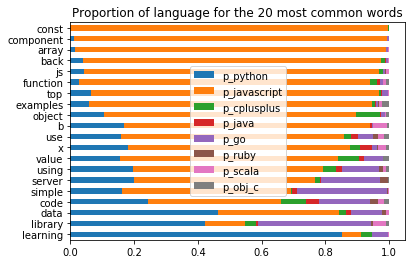

In [40]:
(word_counts
 .assign(p_python = word_counts.python / word_counts['all'],
         p_javascript = word_counts.javascript / word_counts['all'], 
         p_cplusplus = word_counts.cplusplus / word_counts['all'],
         p_java = word_counts.java / word_counts['all'], 
         p_go = word_counts.go / word_counts['all'], 
         p_ruby = word_counts.ruby / word_counts['all'], 
         p_scala = word_counts.scala / word_counts['all'],
         p_obj_c = word_counts.obj_c / word_counts['all'])
 .sort_values(by='all')
 [['p_python', 'p_javascript', 'p_cplusplus', 'p_java', 'p_go', 'p_ruby', 'p_scala', 'p_obj_c']]
 .tail(20)
 .sort_values('p_javascript')
 .plot.barh(stacked=True))

plt.title('Proportion of language for the 20 most common words')

# So the most common words will likely be good predictors of the language.

# All words:

(-0.5, 799.5, 399.5, -0.5)

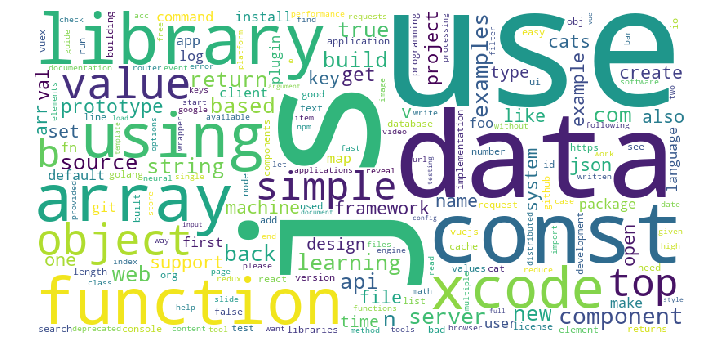

In [41]:
cloud = WordCloud(background_color='white', width=800, height=400)
all_img = cloud.generate_from_frequencies(word_freq_for_all)
plt.figure(figsize=(20, 6))
plt.imshow(all_img)
plt.axis('off')

# Create wordclouds for each language

## javascript

In [42]:
javascript_freq.head(10)

js           1073
const         823
use           774
array         690
function      635
component     466
top           432
x             425
back          409
object        393
dtype: int64

(-0.5, 799.5, 399.5, -0.5)

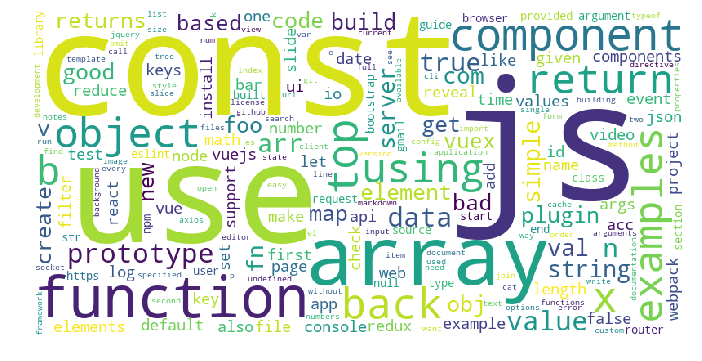

In [43]:
cloud = WordCloud(background_color='white', width=800, height=400)
all_img = cloud.generate_from_frequencies(javascript_freq)
plt.figure(figsize=(20, 6))
plt.imshow(all_img)
plt.axis('off')

### C++

In [44]:
cplusplus_freq.head(10)

build         74
swift         73
cache         58
electron      48
source        46
code          44
object        37
tensorflow    36
windows       36
open          34
dtype: int64

(-0.5, 799.5, 399.5, -0.5)

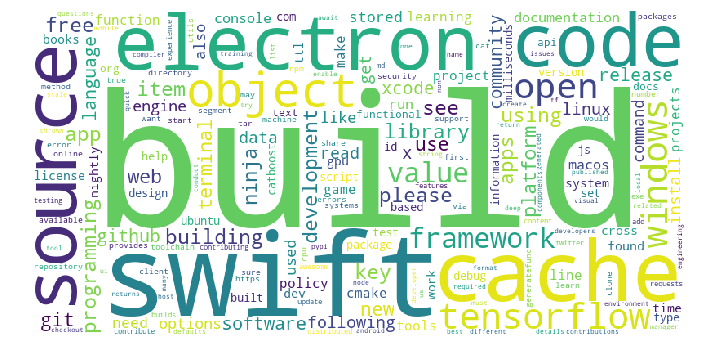

In [45]:
cloud = WordCloud(background_color='white', width=800, height=400)
all_img = cloud.generate_from_frequencies(cplusplus_freq)
plt.figure(figsize=(20, 6))
plt.imshow(all_img)
plt.axis('off')

In [46]:
python_freq.head(10)

data          424
learning      388
library       327
machine       290
use           176
deprecated    163
system        155
source        153
design        135
command       135
dtype: int64

(-0.5, 799.5, 399.5, -0.5)

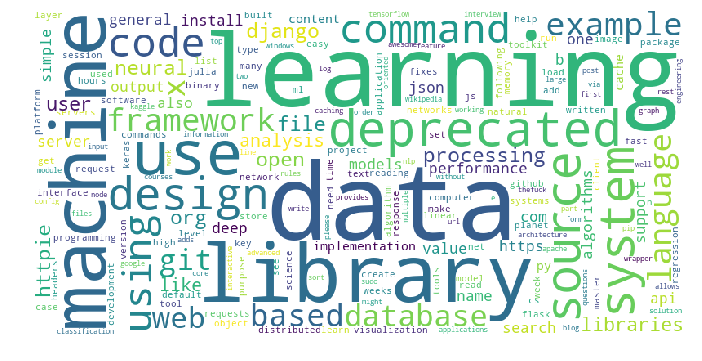

In [47]:
cloud = WordCloud(background_color='white', width=800, height=400)
all_img = cloud.generate_from_frequencies(python_freq)
plt.figure(figsize=(20, 6))
plt.imshow(all_img)
plt.axis('off')

In [48]:
java_freq.head(10)

license     41
rxjava      39
type        37
flowable    34
single      29
io          28
operator    27
system      27
index       26
source      25
dtype: int64

(-0.5, 799.5, 399.5, -0.5)

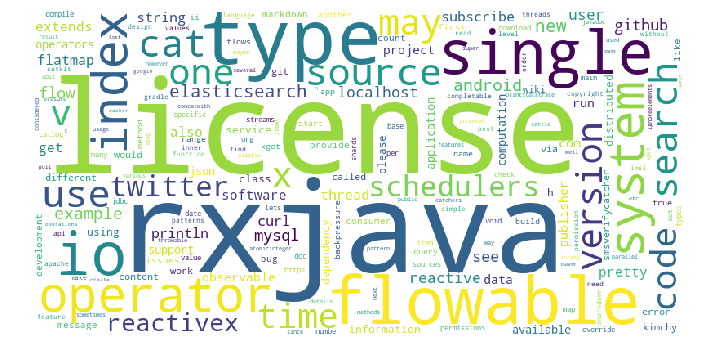

In [49]:
cloud = WordCloud(background_color='white', width=800, height=400)
all_img = cloud.generate_from_frequencies(java_freq)
plt.figure(figsize=(20, 6))
plt.imshow(all_img)
plt.axis('off')

In [50]:
go_freq.head(10)

library      272
golang       198
package      140
simple       139
api          113
client        93
based         92
code          89
data          88
framework     88
dtype: int64

(-0.5, 799.5, 399.5, -0.5)

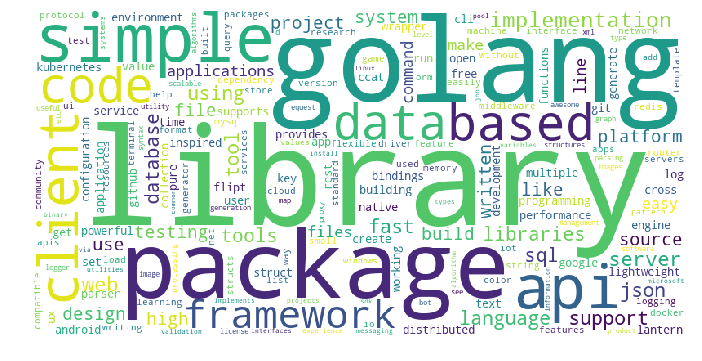

In [51]:
cloud = WordCloud(background_color='white', width=800, height=400)
all_img = cloud.generate_from_frequencies(go_freq)
plt.figure(figsize=(20, 6))
plt.imshow(all_img)
plt.axis('off')

In [52]:
ruby_freq.head(10)

rails      37
cat        19
use        17
catarse    17
nyan       17
run        16
action     14
project    13
button     13
com        13
dtype: int64

(-0.5, 799.5, 399.5, -0.5)

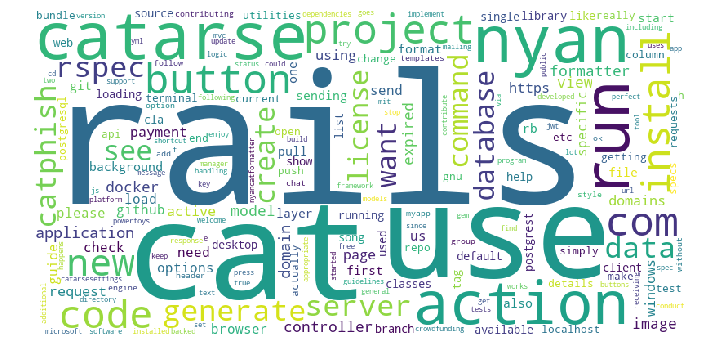

In [53]:
cloud = WordCloud(background_color='white', width=800, height=400)
all_img = cloud.generate_from_frequencies(ruby_freq)
plt.figure(figsize=(20, 6))
plt.imshow(all_img)
plt.axis('off')

In [54]:
scala_freq.head(10)

cats          185
typelevel      41
org            36
thrpt          36
string         35
type           32
library        32
version        31
show           27
functional     27
dtype: int64

(-0.5, 799.5, 399.5, -0.5)

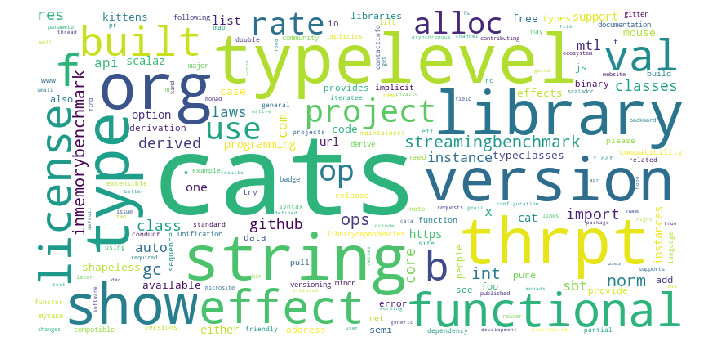

In [55]:
cloud = WordCloud(background_color='white', width=800, height=400)
all_img = cloud.generate_from_frequencies(scala_freq)
plt.figure(figsize=(20, 6))
plt.imshow(all_img)
plt.axis('off')

In [56]:
obj_c_freq.head(10)

rx                     82
match                  43
nsstring               40
string                 40
show                   28
nsregularexpression    25
replace                22
matches                20
cats                   20
f                      19
dtype: int64

(-0.5, 799.5, 399.5, -0.5)

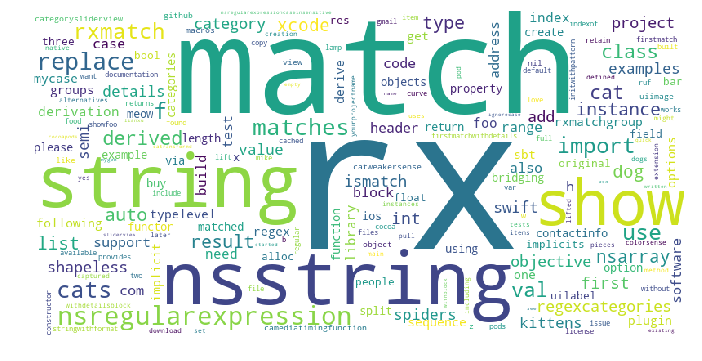

In [57]:
cloud = WordCloud(background_color='white', width=800, height=400)
all_img = cloud.generate_from_frequencies(obj_c_freq)
plt.figure(figsize=(20, 6))
plt.imshow(all_img)
plt.axis('off')

In [58]:
word_freq_for_all.values[:10]

array([1157, 1105,  913,  826,  772,  706,  698,  639,  610,  546])

In [59]:
combined_freq_df = pd.DataFrame()
combined_freq_df['allw'] = word_freq_for_all.index[:10]
combined_freq_df['allv'] = word_freq_for_all.values[:10]

combined_freq_df['cpp_w'] = cplusplus_freq.index[:10]
combined_freq_df['cpp_v'] = cplusplus_freq.values[:10]

combined_freq_df['python_w'] = python_freq.index[:10]
combined_freq_df['python_v'] = python_freq.values[:10]

combined_freq_df['java_w'] = java_freq.index[:10]
combined_freq_df['java_v'] = java_freq.values[:10]

combined_freq_df['go_w'] = go_freq.index[:10]
combined_freq_df['go_v'] = go_freq.values[:10]

combined_freq_df['ruby_w'] = ruby_freq.index[:10]
combined_freq_df['ruby_v'] = ruby_freq.values[:10]

combined_freq_df['scala_w'] = scala_freq.index[:10]
combined_freq_df['scala_v'] = scala_freq.values[:10]

combined_freq_df['obj_c_w'] = obj_c_freq.index[:10]
combined_freq_df['obj_c_v'] = obj_c_freq.values[:10]

combined_freq_df

,allw,allv,cpp_w,cpp_v,python_w,python_v,java_w,java_v,go_w,go_v,ruby_w,ruby_v,scala_w,scala_v,obj_c_w,obj_c_v
0,js,1157,build,74,data,424,license,41,library,272,rails,37,cats,185,rx,82
1,use,1105,swift,73,learning,388,rxjava,39,golang,198,cat,19,typelevel,41,match,43
2,data,913,cache,58,library,327,type,37,package,140,use,17,org,36,nsstring,40
3,const,826,electron,48,machine,290,flowable,34,simple,139,catarse,17,thrpt,36,string,40
4,library,772,source,46,use,176,single,29,api,113,nyan,17,string,35,show,28
5,array,706,code,44,deprecated,163,io,28,client,93,run,16,type,32,nsregularexpression,25
6,function,698,object,37,system,155,operator,27,based,92,action,14,library,32,replace,22
7,using,639,tensorflow,36,source,153,system,27,code,89,project,13,version,31,matches,20
8,x,610,windows,36,design,135,index,26,data,88,button,13,show,27,cats,20
9,code,546,open,34,command,135,source,25,framework,88,com,13,functional,27,f,19


## Consider the sentiment score for each language.

In [60]:
sentiment_score = pd.DataFrame()
sentiment_score['all'] = int(afinn.score(all_words))
sentiment_score['javascript'] = int(afinn.score(javascript_words))
sentiment_score['cpp'] = int(afinn.score(cplusplus_words))
sentiment_score['python'] = int(afinn.score(python_words))
sentiment_score['java'] = int(afinn.score(java_words))
sentiment_score['go'] = int(afinn.score(go_words))
sentiment_score['java'] = int(afinn.score(rust_words))
sentiment_score

NameError: name 'afinn' is not defined